> Needs inference + clean up

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

from tqdm.notebook import trange, tqdm

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForTokenClassification, BertTokenizer, BertConfig
from transformers import DistilBertForTokenClassification, DistilBertTokenizer, DistilBertConfig
from transformers import RobertaForTokenClassification, RobertaTokenizer, RobertaConfig

from seqeval.metrics import accuracy_score, f1_score, classification_report

In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.59
transformers version : 2.2.0


In [3]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

# Data

### Prepare for NER

In [4]:
import cv2
import os
import shutil
import glob
import numpy as np
from tqdm import tqdm
import csv
import json
from collections import defaultdict
import re

In [5]:
IMG_DIR = '../data/sroie2019/task3_train_img/'
GT_DIR = '../data/sroie2019/task3_train_gt/'
TXT_DIR = '../data/sroie2019/train_gt/'

In [6]:
JSON_KEYS = ['company', 'date', 'address', 'total']
NER_TAGS = ['CMP', 'DAT', 'ADD', 'TOT']
OTHER_TAG = 'O'

In [7]:
def read_data(csv_path):
    ''' returns [([4,2], str),...] '''
    out = []
    with open(csv_path, encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for line in csv_reader:
            if len(line) > 8:
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(int, line[:8]))
                label = ','.join(line[8:])
                points = np.array([ [x1, y1], [x2, y2], [x3, y3], [x4, y4] ])
                out.append([points, label])
    return out

def read_json(path):
    ''' returns dict w/ 'company', 'date', 'address', 'total' '''
    with open(path, encoding="utf8") as json_file:
        out = json.load(json_file)
    return out

def calc_center(points): # [4,2]
    y = np.mean(points[:,1])
    x = np.min(points[:,0])
    return np.array([x,y], dtype=points.dtype)

def sort_by_x(arr):
    return [label for x, label in sorted(arr, key=lambda x: x[0])]

def parse_gts(gts):
    ''' gts: list of [(points,str),...], points - [4,2] array 
    returns list [[str1,str2], [str1,...], ...], where each element is line in document (y is the same)
    '''
    gts = [(calc_center(points), label) for points, label in gts]

    lines = defaultdict(lambda: [])
    y_prev, current_line = -1, 0

    for (x,y), label in sorted(gts, key=lambda x: (x[0][1])):
        if y - y_prev > 10:
            if y_prev != -1: lines[current_line] = sort_by_x(lines[current_line])
            current_line += 1
        lines[current_line].append((x,label)) # append x to sort later w/ sort_by_x
        y_prev = y

    lines[current_line] = sort_by_x(lines[current_line]) # sort last line

    return [labels for l, labels in lines.items()]

def tokenize(text, tokenizer):
    ''' return list of words '''
    tokens = tokenizer(text)
    return [t.text for t in tokens]

In [8]:
total = 0
print('checking...')
for fn in os.listdir(GT_DIR):
    j = read_json(os.path.join(GT_DIR, fn))

    for s in JSON_KEYS:
        if s not in j:
            total += 1
            print('check {} file'.format(fn))

print('total missing:', total)

checking...
check X51005663280.txt file
total missing: 1


In [9]:
def text_fn(text, pattern = re.compile('[^a-zA-Z0-9\ \-\.\,\/\:\%\@\&\$]')):
    return pattern.sub('', text).lower()

In [10]:
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

#### Example

In [11]:
fn = 'X00016469612'

gts = read_data('../data/sroie2019/train_gt/' +fn+ '.txt')
ats = read_json('../data/sroie2019/task3_train_gt/' +fn+ '.txt')
ats

{'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD',
 'date': '25/12/2018',
 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.',
 'total': '9.00'}

In [12]:
def parse_document(gts):
    lines = parse_gts(gts)
    # lines = [' '.join([text_fn(word) for word in line]) for line in lines]
    lines = [' '.join(line) for line in lines]
    lines = [text_fn(l) for l in lines]
    document = '\n'.join(lines) # join lines to string
    return document

gts = read_data('../data/sroie2019/train_gt/' +fn+ '.txt')
document = parse_document(gts)
document

'tan woon yann\nbook ta .ktaman daya sdn bnd\n789417-w\nno.53 55,57 & 59, jalan sagu 18,\ntaman daya,\n81100 johor bahru,\njohor.\ndocument no : td01167104\ndate: 25/12/2018 8:13:39 pm\ncashier: manis\nmember:\ncash bill\ncode/desc price disc amount\nqty rm rm\n9556939040116 kf modelling clay kiddy fish\n1 pc  9.000 0.00 9.00\ntotal: 9.00\nrour ding adjustment: 0.00\nround d total rm: 9.00\ncash 10.00\nchange 1.00\ngoods sold are not returnable or\nexchangeable\n\n\nthank you\nplease come again '

In [13]:
def is_interesting(word):
    requirement_bool_list = ['\n' not in word,
    word not in ['.', '', ' ', '(', ')', ',', '{', '}', '/']
    ] 
    return not (False in requirement_bool_list)

def info2labels(info_dict, tokenizer): # info_dict (from read_json func)
    ''' returns list of [TAG, WORD] pairs '''
    labels = []
    for key, tag in zip(JSON_KEYS, NER_TAGS):
        if key in info_dict:
            string = info_dict[key]
            for i, word in enumerate(tokenize(string, tokenizer)):
                word = text_fn(word)
                if is_interesting(word):
                    pretag = 'B-' if i == 0 else 'I-'
                    labels.append( (pretag + tag, word) )
    return labels
labels = info2labels(ats, tokenizer)
print(labels)

[('B-CMP', 'book'), ('I-CMP', 'ta'), ('I-CMP', '.k'), ('I-CMP', 'taman'), ('I-CMP', 'daya'), ('I-CMP', 'sdn'), ('I-CMP', 'bhd'), ('B-DAT', '25/12/2018'), ('B-ADD', 'no.53'), ('I-ADD', '55,57'), ('I-ADD', '&'), ('I-ADD', '59'), ('I-ADD', 'jalan'), ('I-ADD', 'sagu'), ('I-ADD', '18'), ('I-ADD', 'taman'), ('I-ADD', 'daya'), ('I-ADD', '81100'), ('I-ADD', 'johor'), ('I-ADD', 'bahru'), ('I-ADD', 'johor'), ('B-TOT', '9.00')]


In [14]:
labels

[('B-CMP', 'book'),
 ('I-CMP', 'ta'),
 ('I-CMP', '.k'),
 ('I-CMP', 'taman'),
 ('I-CMP', 'daya'),
 ('I-CMP', 'sdn'),
 ('I-CMP', 'bhd'),
 ('B-DAT', '25/12/2018'),
 ('B-ADD', 'no.53'),
 ('I-ADD', '55,57'),
 ('I-ADD', '&'),
 ('I-ADD', '59'),
 ('I-ADD', 'jalan'),
 ('I-ADD', 'sagu'),
 ('I-ADD', '18'),
 ('I-ADD', 'taman'),
 ('I-ADD', 'daya'),
 ('I-ADD', '81100'),
 ('I-ADD', 'johor'),
 ('I-ADD', 'bahru'),
 ('I-ADD', 'johor'),
 ('B-TOT', '9.00')]

In [15]:
for i, word in enumerate(tokenize(document, tokenizer)):
    if word == '\n': print()
    else: print([word], end=' ')

['tan'] ['woon'] ['yann'] 
['book'] ['ta'] ['.ktaman'] ['daya'] ['sdn'] ['bnd'] 
['789417-w'] 
['no.53'] ['55,57'] ['&'] ['59'] [','] ['jalan'] ['sagu'] ['18'] [','] 
['taman'] ['daya'] [','] 
['81100'] ['johor'] ['bahru'] [','] 
['johor'] ['.'] 
['document'] ['no'] [':'] ['td01167104'] 
['date'] [':'] ['25/12/2018'] ['8:13:39'] ['pm'] 
['cashier'] [':'] ['manis'] 
['member'] [':'] 
['cash'] ['bill'] 
['code'] ['/'] ['desc'] ['price'] ['disc'] ['amount'] 
['qty'] ['rm'] ['rm'] 
['9556939040116'] ['kf'] ['modelling'] ['clay'] ['kiddy'] ['fish'] 
['1'] ['pc'] [' '] ['9.000'] ['0.00'] ['9.00'] 
['total'] [':'] ['9.00'] 
['rour'] ['ding'] ['adjustment'] [':'] ['0.00'] 
['round'] ['d'] ['total'] ['rm'] [':'] ['9.00'] 
['cash'] ['10.00'] 
['change'] ['1.00'] 
['goods'] ['sold'] ['are'] ['not'] ['returnable'] ['or'] 
['exchangeable'] ['\n\n\n'] ['thank'] ['you'] 
['please'] ['come'] ['again'] 

In [16]:
def tag_string(document:str, labels:list, tokenizer): # labels: list of <tag, str> pairs
    used_labels = []
    tags = []
    words = []
    for i, word in enumerate(tokenize(document, tokenizer)):

        word_tags = []
        for tag, word_label in labels:
            if word == word_label: # and not word_label in used_labels:
                word_tags.append(tag)

        if len(word_tags) == 0:
            word_tag = OTHER_TAG
    #     elif len(word_tags) == 1:
    #         word_tag = word_tags[0]
        else:
            idx = np.zeros([len(word_tags)])
            for i, tag in enumerate(word_tags):
                for how_much_away,w in enumerate(reversed(tags)):
                    if tag[2:] == w[2:]:
                        idx[i] = -how_much_away
                        break

            word_tag = word_tags[np.argmin(idx)]

    #     used_labels.append(word_label)
        if is_interesting(word): # or word == '\n':
            tags.append(word_tag)
            words.append(word)

        if len(tags) > 2:
            # change in the middle `O`s to `I-` something
            w3,w2,w1 = tags[-3:]
            if w1 != OTHER_TAG and w1.startswith('I-') and is_interesting(w2):
                if w2 == OTHER_TAG and (w3.startswith('B-') or w3.startswith('I-')) and w3[2:] == w1[2:]:
                    tags[-2] = w1
            # TODO remove I- w/out B-
    return words, tags

In [17]:
words, tags = tag_string(document, labels, tokenizer)
for tag,word in zip(tags, words):
    if word == '\n': print(('/n', tag))
    else: print((word, tag), end=' ')

('tan', 'O') ('woon', 'O') ('yann', 'O') ('book', 'B-CMP') ('ta', 'I-CMP') ('.ktaman', 'I-CMP') ('daya', 'I-CMP') ('sdn', 'I-CMP') ('bnd', 'O') ('789417-w', 'O') ('no.53', 'B-ADD') ('55,57', 'I-ADD') ('&', 'I-ADD') ('59', 'I-ADD') ('jalan', 'I-ADD') ('sagu', 'I-ADD') ('18', 'I-ADD') ('taman', 'I-CMP') ('daya', 'I-ADD') ('81100', 'I-ADD') ('johor', 'I-ADD') ('bahru', 'I-ADD') ('johor', 'I-ADD') ('document', 'O') ('no', 'O') (':', 'O') ('td01167104', 'O') ('date', 'O') (':', 'O') ('25/12/2018', 'B-DAT') ('8:13:39', 'O') ('pm', 'O') ('cashier', 'O') (':', 'O') ('manis', 'O') ('member', 'O') (':', 'O') ('cash', 'O') ('bill', 'O') ('code', 'O') ('desc', 'O') ('price', 'O') ('disc', 'O') ('amount', 'O') ('qty', 'O') ('rm', 'O') ('rm', 'O') ('9556939040116', 'O') ('kf', 'O') ('modelling', 'O') ('clay', 'O') ('kiddy', 'O') ('fish', 'O') ('1', 'O') ('pc', 'O') ('9.000', 'O') ('0.00', 'O') ('9.00', 'B-TOT') ('total', 'O') (':', 'O') ('9.00', 'B-TOT') ('rour', 'O') ('ding', 'O') ('adjustment', 'O

In [18]:
ats

{'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD',
 'date': '25/12/2018',
 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.',
 'total': '9.00'}

### Converter

In [19]:
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [20]:
document_data = [] # <list[word], list[tag]> pairs
for fn in tqdm(os.listdir(GT_DIR), total=len(os.listdir(GT_DIR))):
    gts = read_data(os.path.join(TXT_DIR, fn))
    ats = read_json(os.path.join(GT_DIR, fn))
    document = parse_document(gts)
    labels = info2labels(ats, tokenizer)
    words, tags = tag_string(document, labels, tokenizer)
    document_data.append((words, tags))

len(document_data)

100%|██████████| 625/625 [00:01<00:00, 510.20it/s]


625

In [21]:
def is_correct(document):
    words, tags = document
    words = ' '.join(words)
    tags = ' '.join(tags)
    words = words.split(' ')
    tags = tags.split(' ')
    return len(words) == len(tags)

document_data = list(filter(is_correct, document_data))
len(document_data)

624

### To pandas

In [22]:
#export
def readdf(filename):
    ''' read file to dataframe '''
    f = open(filename)
    data, sentence, label = [], [], []
    sentence_idx = 0
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                for word, tag in zip(sentence, label):
                    data.append( (word, tag, sentence_idx) )
                sentence_idx += 1
                sentence, label = [], []
            continue
        splits = line.split(' ')
        sentence.append(splits[0])
        label.append(splits[-1][:-1])

    if len(sentence) > 0:
        for word, tag in zip(sentence, label):
            if tag != '':
                data.append( (word, tag, sentence_idx) )
    return pd.DataFrame(data, columns=['word', 'tag', 'sentence_idx'])

In [23]:
# df = readdf('datasets/CONLL2003/valid.txt')
# assert df['sentence_idx'].max()+1 == 3250
# df = readdf('datasets/CONLL2003/test.txt')
# assert df['sentence_idx'].max()+1 == 3453
# df = readdf('datasets/CONLL2003/train.txt')
# assert df['sentence_idx'].max()+1 == 14041

In [24]:
#export
def readdfsentences(document_data, valid_pct=0.2):
    data = []
    for i,document in enumerate(document_data):
        words = [word for word,tag in zip(*document)]
        tags = [tag for word,tag in zip(*document)]
        data.append( (' '.join(words), ' '.join(tags), len(document_data)*valid_pct > i) )
    return pd.DataFrame(data, columns=['sentences', 'labels', 'valid'])

d = readdfsentences(document_data)
d.head()

,sentences,labels,valid
0,a pie thing four quarters sdn bhd 1079369-p no...,O O O B-CMP I-CMP I-CMP I-CMP O B-ADD I-ADD I-...,True
1,three stooges bistro & cafe 109 ss21/1a damans...,B-CMP I-CMP O O O B-ADD I-ADD I-ADD I-ADD O O ...,True
2,3 180048 shell isni petro trading company no :...,O O B-CMP I-CMP I-CMP I-CMP O O O O B-ADD I-AD...,True
3,yam fresh no.145 g jalan rimbunan raya 1 laman...,B-CMP I-CMP B-ADD I-ADD I-ADD I-ADD I-ADD I-AD...,True
4,gardenia bakeries kl sdn bhd 139386 x lot 3 ja...,B-CMP I-CMP I-CMP I-CMP I-CMP O O B-ADD I-ADD ...,True


In [25]:
train_df = readdfsentences(document_data)

### Config

In [26]:
MODEL_CLASSES = {
    'roberta': (RobertaForTokenClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForTokenClassification, DistilBertTokenizer, DistilBertConfig),
    'bert': (BertForTokenClassification, BertTokenizer, BertConfig)
}

In [27]:
# Parameters
seed = 42
use_fp16 = False
bs = 4

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base' # 'roberta-base-openai-detector'

model_type = 'bert'
pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

In [28]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [29]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased'])

In [30]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [31]:
seed_all(seed)

### Tokenizer

In [32]:
# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [33]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [34]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [35]:
tokenizer_class.pretrained_vocab_files_map

{'vocab_file': {'bert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt',
  'bert-large-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt',
  'bert-base-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt',
  'bert-large-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt',
  'bert-base-multilingual-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt',
  'bert-base-multilingual-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt',
  'bert-base-chinese': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt',
  'bert-base-german-cased': 'https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt',
  'bert-large-uncased-whole-word-masking': 'https://s3.amazonaws.c

### Vocab

In [36]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [37]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

### Label config

In [38]:
PAD_label = '<x>'
BOS_label = '<s>'
EOS_label = '</s>'

labels = ["O", "B-CMP", "I-CMP", "B-DAT", "I-DAT", "B-ADD", "I-ADD", "B-TOT", "I-TOT", BOS_label, EOS_label, PAD_label]

### Fix labels (to work for byte encoding)

In [39]:
tokenize_processor.process_one('Hey! \n Goodbye')

['[CLS]', 'hey', '!', 'goodbye', '[SEP]']

In [40]:
def pad_labels(df, PAD='<x>', test_length=False):
    total = 0
    new_labels = []
    for i, (str_sentence, labels) in enumerate(tqdm(zip(df['sentences'], df['labels']), total=len(df['labels']))):
        labels = labels.split(' ')
        sentence = str_sentence.split(' ')
        assert len(sentence) == len(labels)

        padded_labels = []
        for word, label in zip(sentence, labels):

            tokens = tokenize_processor.process_one(word)
            tokens = tokens[1:-1] # remove <s> and </s>

            padded_labels.extend( [label] + [PAD] * int(len(tokens)-1) )

        new_sentence_labels = ' '.join(padded_labels)
        new_labels.append(new_sentence_labels)
        
        if test_length:
            tokens = tokenize_processor.process_one(str_sentence)
            if len(tokens)-2 != len(new_sentence_labels.split(' ')):
                print(i)
                print(len(tokens[1:-1]), len(new_sentence_labels.split(' ')))
#                 print(tokens[1:-1])
#                 print(new_sentence_labels.split(' '))
                total += 1
#             assert len(tokens)-2 == len(new_sentence_labels.split(' '))

    if not test_length:
        df['labels'] = new_labels
    print(total)

In [41]:
# test
# pad_labels(train_df, PAD_label, test_length=True)

In [42]:
train_df = train_df.drop(53).drop(490)

In [43]:
pad_labels(train_df, PAD_label)

100%|██████████| 622/622 [00:39<00:00, 15.76it/s]

0


In [44]:
train_df.head()

,sentences,labels,valid
0,a pie thing four quarters sdn bhd 1079369-p no...,O O O B-CMP I-CMP I-CMP <x> I-CMP <x> O <x> <x...,True
1,three stooges bistro & cafe 109 ss21/1a damans...,B-CMP I-CMP <x> <x> O <x> O O B-ADD I-ADD <x> ...,True
2,3 180048 shell isni petro trading company no :...,O O <x> B-CMP I-CMP <x> I-CMP <x> I-CMP O O O ...,True
3,yam fresh no.145 g jalan rimbunan raya 1 laman...,B-CMP <x> I-CMP B-ADD <x> <x> I-ADD I-ADD I-AD...,True
4,gardenia bakeries kl sdn bhd 139386 x lot 3 ja...,B-CMP <x> I-CMP <x> I-CMP <x> I-CMP <x> I-CMP ...,True


### Labels

In [45]:
class LabelTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, max_seq_len=999, **kwargs):
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        return [BOS_label] + t.split(' ') + [EOS_label]

In [46]:
label_tokenizer = Tokenizer(tok_func = LabelTokenizer(), pre_rules=[], post_rules=[])

In [47]:
class LabelVocab(Vocab):
    def __init__(self, labels):
        super().__init__(itos = [])
        self.int2str = labels
        self.str2int = { s:i for i,s in enumerate(labels) }
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return list(map(lambda i: self.str2int[i], t))
    
    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(list(map(lambda i: self.int2str[i], nums)))

In [48]:
def LabelNumericalizeProcessor(ds, **kwargs):
    return NumericalizeProcessor(ds, vocab=LabelVocab(labels))

In [49]:
def LabelTokenizeProcessor(ds, **kwargs):
    return TokenizeProcessor(ds, tokenizer=label_tokenizer, include_bos=False, include_eos=False)

In [50]:
class TextLabelList(TextList):
    _processor = [LabelTokenizeProcessor, LabelNumericalizeProcessor]

### Databunch

In [51]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [52]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].y, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [53]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextLabelList

In [54]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [55]:
data = (Seq2SeqTextList.from_df(train_df, cols='sentences', processor=transformer_processor)
       .split_from_df(col='valid')
       .label_from_df(cols='labels', label_cls=TextLabelList)
       .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [56]:
# # NOTE: this is more of a hack for getting metrics on test dataset
# # usage: validate_learner(learner, test_dl, metrics=[f1, acc])
# # returns 
# temp = test_df[:31].copy()
# temp['test'] = False
# test_df['test'] = True

# test_df_fastai = pd.concat([test_df, temp])

# # Note: test data is saved in 'data_test' as valid data (this can be confusing)
# data_test = (Seq2SeqTextList.from_df(test_df_fastai, cols='sentences', processor=transformer_processor)
#            .split_from_df(col='test')
#            .label_from_df(cols='labels', label_cls=TextLabelList)
#            .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

# # use only this var: (ex below)
# test_dl = data_test.valid_dl 
# # validate_learner(learner, test_dl, metrics=[f1, acc])

# def validate_learner(learner, dataloader, metrics):
#     class Temp:
#         def update_graph(*args):
#             pass
    
#     learner.losses = [0]
#     learner.nb_batches = [0]
#     learner.val_losses = [0]
#     learner.pbar = Temp()
#     out = learner.validate(dataloader, callbacks=[], metrics=metrics)
#     return out[1:]

In [57]:
i = 2
print((len(data.train_ds[i][0].data), len(data.train_ds[i][1].data)))
data.train_ds[i][0].text, data.train_ds[i][1].text

(191, 191)


('[CLS] dig ##i telecommunications sd ##n b ##hd 2012 ##8 ##3 - m lot l ##g 315 1 - uta ##ma shopping centre le ##bu ##h banda ##r uta ##ma - banda ##r uta ##ma pet ##aling jaya 47 ##80 ##0 selangor tax in ##vo ##ice gs ##t reg number : 001 ##21 ##19 ##57 ##24 ##8 13 / 10 / 2017 12 : 35 po ##s log ##in i d : d ##mg ##r ##34 ##01 ##3 store name : ds ##00 ##1 - bp ##00 ##9 oscar colour lab & telecommunication sd ##n b ##hd 52 ##38 ##47 - w bill payment paid amount 234 . 40 sub total amount 234 . 40 total amount 234 . 40 credit card 234 . 40 credit card no . : xx ##xx xx ##xx xx ##xx 69 ##7 ##4 total amount collected 234 . 40 customer name : lim rue ##y ch ##yi mobile no : 60 ##14 ##31 ##49 ##31 ##9 account no : 1000 ##00 ##45 ##8 ##7 ##10 ##4 customer copy thank you have a nice day 340 ##13 ##00 ##19 ##29 ##12 ##01 ##7 ##10 ##13 [SEP]',
 '<s> B-CMP <x> I-CMP I-CMP <x> I-CMP <x> O <x> <x> <x> <x> B-ADD I-ADD <x> I-ADD I-ADD <x> <x> <x> I-ADD I-ADD I-ADD <x> <x> I-ADD <x> I-ADD <x> I-ADD I

In [58]:
print((data.train_ds[i][0].data, data.train_ds[i][1].data))

(array([  101, 10667,  2072, 12108, ...,  2581, 10790, 17134,   102]), array([ 9,  1, 11,  2, ..., 11, 11, 11, 10]))


In [59]:
# print('[CLS] id :', transformer_tokenizer.cls_token_id)
# print('[SEP] id :', transformer_tokenizer.sep_token_id)
# print('[PAD] id :', pad_idx)
# test_one_batch = data.one_batch()[0]
# print('Batch shape : ',test_one_batch.shape)
# print(test_one_batch)

In [60]:
# a = test_one_batch
# a[1]

### Model & Learner

In [61]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        # input_ids: [b,s] s - words in sentence
        
#         attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        out = self.transformer(input_ids, attention_mask = attention_mask)
        logits = out[0] # [b,s,C]
        return logits

In [62]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = len(labels) - 3 # <s>, </s>, <x>
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}



In [63]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [64]:
custom_transformer_model.transformer.classifier

Linear(in_features=768, out_features=9, bias=True)

In [65]:
pad_nr = labels.index(PAD_label)
bos_nr = labels.index(BOS_label)
eos_nr = labels.index(EOS_label)

def f1(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=-1).view(-1)
    y_true = y_true.view(-1)
    mask = (y_true != pad_nr) * (y_true != bos_nr) * (y_true != eos_nr)
    y_true = list(map(lambda x: labels[x], y_true[mask]))
    y_pred = list(map(lambda x: labels[x], y_pred[mask]))
    return torch.tensor(f1_score(y_true, y_pred))

def acc(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=-1).view(-1)
    y_true = y_true.view(-1)
    mask = (y_true != pad_nr) * (y_true != bos_nr) * (y_true != eos_nr)
    y_true = list(map(lambda x: labels[x], y_true[mask]))
    y_pred = list(map(lambda x: labels[x], y_pred[mask]))
    return torch.tensor(accuracy_score(y_true, y_pred))

In [66]:
loss = CrossEntropyFlat()
def Loss(y_pred, y_true):
    mask = (y_true != pad_nr) * (y_true != bos_nr) * (y_true != eos_nr)
#     print(mask.shape, y_pred.shape, y_true.shape)
    return loss(y_pred[mask], y_true[mask])

In [67]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(data, custom_transformer_model, loss_func=Loss,
                  opt_func = lambda input_: AdamW(input_, correct_bias=False), 
                  metrics=[f1, acc])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [68]:
# print(learner.model)

In [69]:
model_type = 'bert'
if model_type == 'roberta': # For roberta-base
    list_layers = [learner.model.transformer.roberta.embeddings,
                  learner.model.transformer.roberta.encoder.layer[0],
                  learner.model.transformer.roberta.encoder.layer[1],
                  learner.model.transformer.roberta.encoder.layer[2],
                  learner.model.transformer.roberta.encoder.layer[3],
                  learner.model.transformer.roberta.encoder.layer[4],
                  learner.model.transformer.roberta.encoder.layer[5],
                  learner.model.transformer.roberta.encoder.layer[6],
                  learner.model.transformer.roberta.encoder.layer[7],
                  learner.model.transformer.roberta.encoder.layer[8],
                  learner.model.transformer.roberta.encoder.layer[9],
                  learner.model.transformer.roberta.encoder.layer[10],
                  learner.model.transformer.roberta.encoder.layer[11],
                  learner.model.transformer.roberta.pooler,
                  learner.model.transformer.classifier]
    
elif model_type == 'bert':
    list_layers = [learner.model.transformer.bert.embeddings,
                  learner.model.transformer.bert.encoder.layer[0],
                  learner.model.transformer.bert.encoder.layer[1],
                  learner.model.transformer.bert.encoder.layer[2],
                  learner.model.transformer.bert.encoder.layer[3],
                  learner.model.transformer.bert.encoder.layer[4],
                  learner.model.transformer.bert.encoder.layer[5],
                  learner.model.transformer.bert.encoder.layer[6],
                  learner.model.transformer.bert.encoder.layer[7],
                  learner.model.transformer.bert.encoder.layer[8],
                  learner.model.transformer.bert.encoder.layer[9],
                  learner.model.transformer.bert.encoder.layer[10],
                  learner.model.transformer.bert.encoder.layer[11],
                  learner.model.transformer.bert.pooler,
                  learner.model.transformer.classifier]

elif model_type == 'distilbert':
    list_layers = [learner.model.transformer.distilbert.embeddings,
                   learner.model.transformer.distilbert.transformer.layer[0],
                   learner.model.transformer.distilbert.transformer.layer[1],
                   learner.model.transformer.distilbert.transformer.layer[2],
                   learner.model.transformer.distilbert.transformer.layer[3],
                   learner.model.transformer.distilbert.transformer.layer[4],
                   learner.model.transformer.distilbert.transformer.layer[5],
                   learner.model.transformer.classifier]

learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)

Learner split in 15 groups


In [70]:
learner.layer_groups

[Sequential(
   (0): Embedding(30522, 768, padding_idx=0)
   (1): Embedding(512, 768)
   (2): Embedding(2, 768)
   (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   (4): Dropout(p=0.1, inplace=False)
 ), Sequential(
   (0): Linear(in_features=768, out_features=768, bias=True)
   (1): Linear(in_features=768, out_features=768, bias=True)
   (2): Linear(in_features=768, out_features=768, bias=True)
   (3): Dropout(p=0.1, inplace=False)
   (4): Linear(in_features=768, out_features=768, bias=True)
   (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   (6): Dropout(p=0.1, inplace=False)
   (7): Linear(in_features=768, out_features=3072, bias=True)
   (8): Linear(in_features=3072, out_features=768, bias=True)
   (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   (10): Dropout(p=0.1, inplace=False)
 ), Sequential(
   (0): Linear(in_features=768, out_features=768, bias=True)
   (1): Linear(in_features=768, out_features=768, bias=True)
   (2): Linear(in_features=

### Training

#### -1 layers

In [71]:
learner.freeze_to(-1)
# learner.summary()

epoch,train_loss,valid_loss,f1,acc,time
0,0.303594,0.268905,0.376858,0.914834,00:09


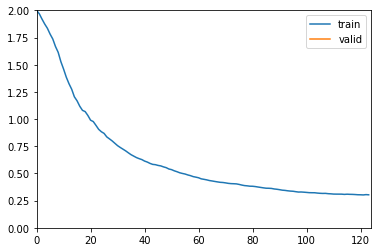

In [72]:
lr = 1e-3
learner.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.9))

epoch,train_loss,valid_loss,f1,acc,time
0,0.227101,0.242183,0.402093,0.921307,00:09
1,0.204657,0.206073,0.474374,0.932313,00:09
2,0.188243,0.193783,0.501980,0.934543,00:09
3,0.173894,0.187132,0.530122,0.938409,00:09
4,0.169298,0.186832,0.533086,0.938349,00:09


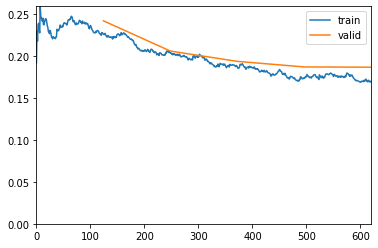

In [73]:
learner.fit_one_cycle(5, max_lr=lr, moms=(0.8, 0.9))

#### -4 layers

In [76]:
learner.freeze_to(-4)

epoch,train_loss,valid_loss,f1,acc,time
0,0.153758,0.150119,0.607336,0.949056,00:11
1,0.130194,0.128725,0.687856,0.959719,00:11
2,0.107350,0.117642,0.723018,0.961782,00:11
3,0.088011,0.112916,0.757273,0.964184,00:11
4,0.068872,0.095350,0.761576,0.969258,00:11
5,0.049968,0.086904,0.790555,0.974171,00:11
6,0.038292,0.089613,0.781628,0.972497,00:11
7,0.031367,0.080637,0.793250,0.975812,00:11
8,0.027924,0.081521,0.799396,0.976151,00:11
9,0.025193,0.080632,0.803329,0.976706,00:11


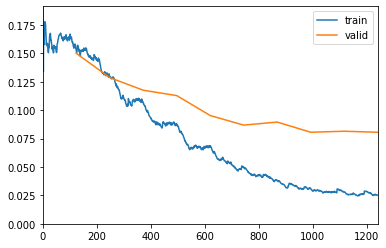

In [77]:
lr = 1e-4
learner.fit_one_cycle(10, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

freeze to: -5


epoch,train_loss,valid_loss,f1,acc,time
0,0.024228,0.118917,0.772030,0.970737,00:12
1,0.039782,0.098202,0.781897,0.973412,00:12
2,0.024911,0.095323,0.813967,0.978156,00:12
3,0.012666,0.088693,0.839349,0.980415,00:12
4,0.008258,0.089601,0.838317,0.980514,00:12


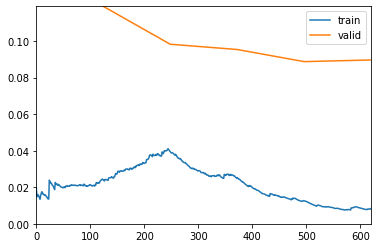

freeze to: -7


epoch,train_loss,valid_loss,f1,acc,time
0,0.026644,0.116546,0.780991,0.974584,00:14
1,0.051674,0.099330,0.792652,0.973775,00:15
2,0.024539,0.087218,0.830296,0.979721,00:14
3,0.011304,0.092221,0.840778,0.981018,00:15
4,0.005720,0.094649,0.836638,0.980933,00:15


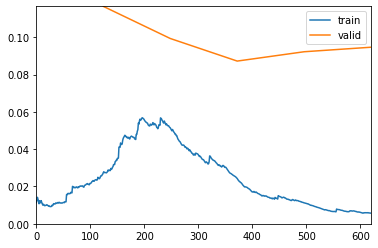

freeze to: -9


epoch,train_loss,valid_loss,f1,acc,time
0,0.029009,0.105832,0.773435,0.972583,00:17
1,0.046518,0.103243,0.796955,0.976098,00:17
2,0.023895,0.079908,0.842354,0.981604,00:17
3,0.011633,0.087416,0.844704,0.980969,00:17
4,0.005690,0.088831,0.849543,0.981756,00:17


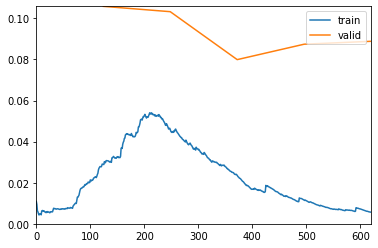

freeze to: -11


epoch,train_loss,valid_loss,f1,acc,time
0,0.024131,0.117937,0.791722,0.973860,00:19
1,0.041980,0.113500,0.748128,0.968420,00:19
2,0.022691,0.097398,0.840678,0.980413,00:19
3,0.007802,0.088077,0.858887,0.983200,00:19
4,0.004802,0.089011,0.861685,0.982950,00:19


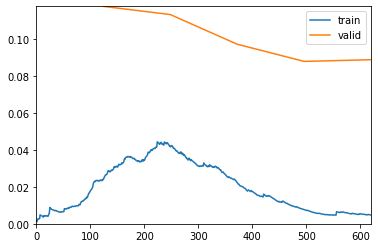

freeze to: -13


epoch,train_loss,valid_loss,f1,acc,time
0,0.019518,0.092758,0.818958,0.978708,00:21
1,0.043666,0.103607,0.814434,0.977516,00:21
2,0.027636,0.083630,0.849680,0.981143,00:21
3,0.009158,0.084356,0.860706,0.983890,00:21
4,0.003655,0.085883,0.863383,0.984111,00:21


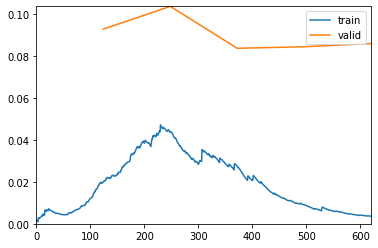

In [79]:
lr = 1e-4
for i in range(5,14,4):
    print('freeze to:', -i)
    learner.freeze_to(-i)
    learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

#### all layers

In [80]:
learner.unfreeze()

epoch,train_loss,valid_loss,f1,acc,time
0,0.001494,0.114431,0.873651,0.984596,00:23
1,0.001195,0.116587,0.875520,0.984855,00:23
2,0.001162,0.118826,0.873358,0.984510,00:24
3,0.001914,0.118247,0.867235,0.983975,00:23
4,0.002169,0.116150,0.870392,0.984049,00:23
5,0.002945,0.111000,0.865224,0.983836,00:23
6,0.003927,0.107809,0.867051,0.983594,00:24
7,0.004857,0.110275,0.848316,0.982187,00:23
8,0.008337,0.109673,0.818082,0.979122,00:23
9,0.009986,0.101751,0.836015,0.978567,00:23


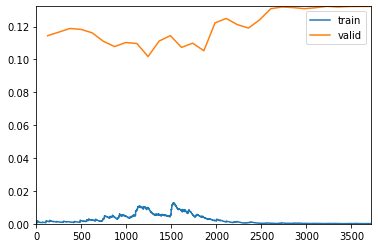

In [82]:
lr = 1e-4
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

### Test

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

def save_lists(y_pred, y_true):
    global y_true_all, y_pred_all
    y_pred = torch.argmax(y_pred, dim=-1).view(-1)
    y_true = y_true.view(-1)
    mask = (y_true != pad_nr) * (y_true != bos_nr) * (y_true != eos_nr)
    y_true = list(map(lambda x: labels[x], y_true[mask]))
    y_pred = list(map(lambda x: labels[x], y_pred[mask]))
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)
    return torch.tensor(1)

In [ ]:
global y_true_all, y_pred_all
y_true_all, y_pred_all = [], []

_ = validate_learner(learner, test_dl, metrics=[save_lists])

In [ ]:
f1_score(y_true_all, y_pred_all)*100, accuracy_score(y_true_all, y_pred_all)*100   

In [ ]:
print(classification_report(y_true_all, y_pred_all))